In [1]:
"""
This notebook shows some basic and popular debluring and denoising algorithms.  
1. Wiener Deconvolution
2. Variational Approach
    (a). Deconvolution by L2 Regularization (Tikhonov model)
    (b). Deconvolution by Total Variation(TV/L1) Regularization (ROF model)

Author: Yingying Gu
Date: 2016-10-26
"""

print __doc__



This notebook shows some basic and popular debluring and denoising algorithms.  
1. Wiener Deconvolution
2. Variational Approach
    (a). Deconvolution by L2 Regularization (Tikhonov model)
    (b). Deconvolution by Total Variation(TV/L1) Regularization (ROF model)

Author: Yingying Gu
Date: 2016-10-26



(<matplotlib.image.AxesImage at 0x7f711ca31790>,
 <matplotlib.text.Text at 0x7f711ca55d50>)

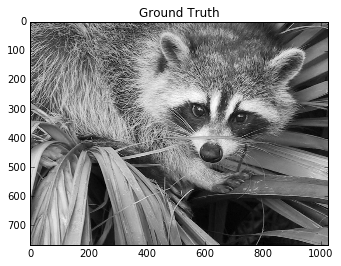

In [2]:
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
ref = misc.face(gray=True)
plt.imshow(ref, cmap=plt.cm.gray), plt.title('Ground Truth')

In [3]:
# calculate the peak signal-to-noise ratio (PSNR)
def PSNR(ref, recon):
    M,N=ref.shape
    maxval=np.amax([np.amax(ref),np.amax(recon)])
    MSE=np.sum((ref-recon)**2)/(M*N)
    psnr=10.0*np.log10(maxval**2/MSE)
    return psnr
    

PSNR= 22.6781797205


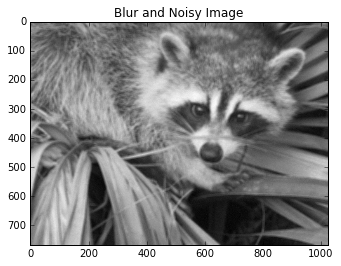

In [4]:
# Blur the ref image and add Gaussian noise to the image
from scipy import signal
import numpy as np
ref = np.array(ref)
M,N=ref.shape
K=np.ones([9,9]) # average kernel
K=K/K.sum()
B = signal.convolve2d(ref, K, mode='same', boundary='symm') # blurred face
sigma=3
Bn = B+np.random.randn(M,N)*sigma # add Gaussian noise
plt.imshow(Bn, cmap=plt.cm.gray), plt.title('Blur and Noisy Image')
print 'PSNR=', PSNR(ref,Bn)

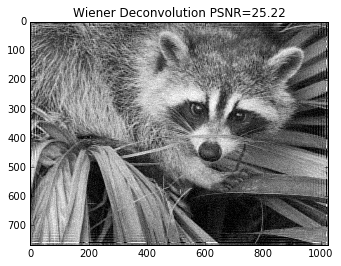

In [5]:
# Wiener Deconvolution
# Definition and Derivation: https://en.wikipedia.org/wiki/Wiener_deconvolution
from scipy import fftpack
H=np.fft.fft2(K, s=[M,N]) 
F=np.fft.fft2(Bn)
NSR=5.0/1000.0  # noise-to-signal ratio

G=np.conjugate(H)/((abs(H))**2+NSR)
wienerDecon=(np.fft.ifft2(F*G)).real
plt.imshow(wienerDecon,cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.title('Wiener Deconvolution PSNR='+ str("{0:.2f}".format(PSNR(ref, wienerDecon))))

In [6]:
# calculate the gradient of 2D image
def grad(u):
    gradfx=np.zeros([M,N])
    gradfx[:M-1,:]=u[1:,:]
    gradfx[M-1,:]=u[M-1,:]
    gradfx=gradfx-u

    gradfy=np.zeros([M,N])
    gradfy[:,:N-1]=u[:,1:]
    gradfy[:,N-1]=u[:,N-1]
    gradfy=gradfy-u
    return gradfx, gradfy

In [7]:
# calculate the gradient of 2D image
def div(gfx,gfy):
    gx=np.zeros([M,N])
    gx[0,:]=gfx[0,:]
    gx[1:,:]=gfx[:M-1,:]
    gx=gfx-gx;
    gx[0,:]=gfx[0,:]
    gx[M-1,:]=-gfx[M-2,:]
    
    gy=np.zeros([M,N])
    gy[:,0]=gfy[:,0]
    gy[:,1:]=gfy[:,:N-1]
    gy=gfy-gy;
    gy[:,0]=gfy[:,0]
    gy[:,N-1]=-gfy[:,N-2]
    
    return gx+gy

In [ ]:
# Deconvolution by Total Variation(TV/L1) Regularization (ROF model)
import math
lmda = 0.05 # regularization parameter for TV term
epsilon = 1e-3
tau = 0.5 # step size
u = np.ones([M,N]) # initital image

# Using iterative Gradient Descent method to minimize the cost function with TV regularization
for iter in range(100):
    gradfx, gradfy=grad(Bn)
    normgrad=pow(gradfx**2+gradfy**2+epsilon,0.5)
    v=signal.convolve2d(u, K, mode='same', boundary='symm')-Bn
    vh=signal.convolve2d(v, K, mode='same', boundary='symm')
    u=u-tau*(vh-lmda*div(gradfx/normgrad, gradfy/normgrad))

recon=u
plt.imshow(recon,cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.title('ROF Deconvolution PSNR='+ str("{0:.2f}".format(PSNR(ref, recon))))